# Smoothing humidity measurements

There is a periodical noise component to the humidity measurements in the GH, due to a humidifying system being activated something like every $5$ minutes. In order to accuractely assess the effect of other varaibles on the indoors humidity, we would like to filter out the effect of the humidifying system.

### Get dependencies and data

In [1]:
# import dependencies
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [4]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [72]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)

In [73]:
# define X vars - we are only concerned with GH pressure and temperature
x_vars = [
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT401_GM401'),
    ('humidity', 'TA02_GT401_GM401')
]

In [74]:
# filter columns to keep only x_vars
data = data[x_vars].copy()
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

# remove NANs
data = data.dropna(
    how='any', 
    subset=x_vars
)

# drop "humidity" from MultiIndex since all from there :)
data = data.droplevel(level=0, axis=1)
x_vars = [var[-1] for var in x_vars]

Number of NAs

category  sensor_ID       
humidity  DC_GT101_GM101      0
          DC_GT102_GM102      0
          DC_GT103_GM103      0
          DC_GT104_GM104      0
          TA01_GT10X_GM10X    0
          TA01_GT401_GM401    0
          TA02_GT401_GM401    0
dtype: int64





### Plot the problem

C:\Users\Oskar\AppData\Local\Temp\ipykernel_36440\712179082.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = data.loc[(2, 21)][x_vars[:4]].copy()


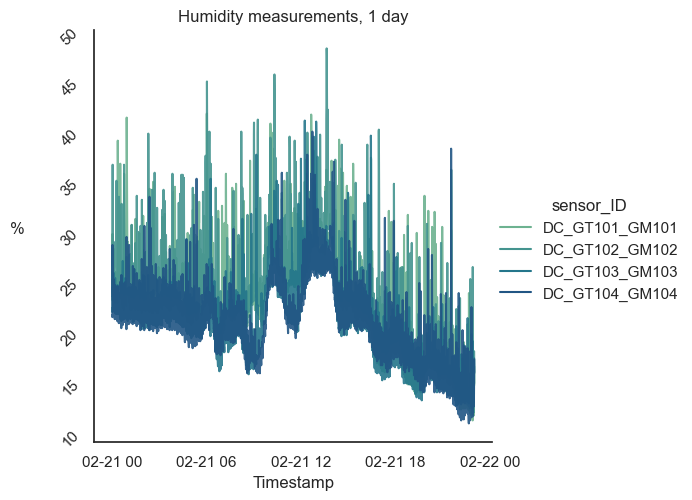

In [88]:
# set seaborn style/theme
sns.set_theme()
sns.set_style('white')

# create subset f. plotting, remove all date indices except DateTime
subset = data.loc[(2, 21)][x_vars[:4]].copy()
subset = subset.droplevel(
    #level=[0, 1, 2], 
    level=0,
    axis=0
)

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='crest',
    alpha=0.9,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=1.5
)

ax.set_xticklabels(step=2)

plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('Humidity measurements, 1 day')

fpath = plot_path + 'humidity_1d.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()

### Moving average

We know that the short-term oscillations in humidity are due to a humidifying system in the GH which is activated every 5-ish minutes. Hence, it would seem to make sense to start by considering a moving average per $10$ steps, since we have two measurements per minute.

We consider the average of the four humidity sensors in the GH, i.e. TA01_GT10X_GM10X.

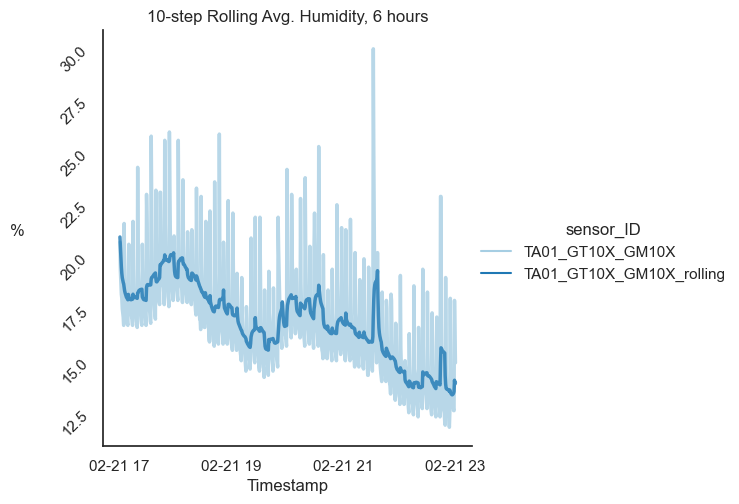

In [174]:
# compute the rolling mean using "pd.rolling"
data['TA01_GT10X_GM10X_rolling'] = data.TA01_GT10X_GM10X.rolling(window=10).mean().droplevel(level=[0, 1, 2,], axis=0).values

subset = data[[
    'TA01_GT10X_GM10X',
    'TA01_GT10X_GM10X_rolling'
]].copy()

subset = subset.droplevel(
    level=[0, 1, 2], 
    axis=0
)

# consider last 720 observations, i.e. 6 hrs.
subset = subset.iloc[-720:]

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='Paired',
    alpha=0.8,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=2.5
)

ax.set_xticklabels(step=2)

plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('10-step Rolling Avg. Humidity, 6 hours')

fpath = plot_path + 'rolling_humidity_6h.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()

### FFT Smoothing

Since we know that there is a periodical component to the data, we might try to smooth out the periodical fluctuations using the Fast Fourier Transform (FFT).

In [170]:
# perform FFT 
fourier = np.fft.rfft(data.TA01_GT10X_GM10X.values)

# get FREQS
spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered1 = np.fft.irfft(fourier)

# perform inverse transform
threshold = 1 / 10
fourier[freqs > threshold] = 0
filtered2 = np.fft.irfft(fourier)

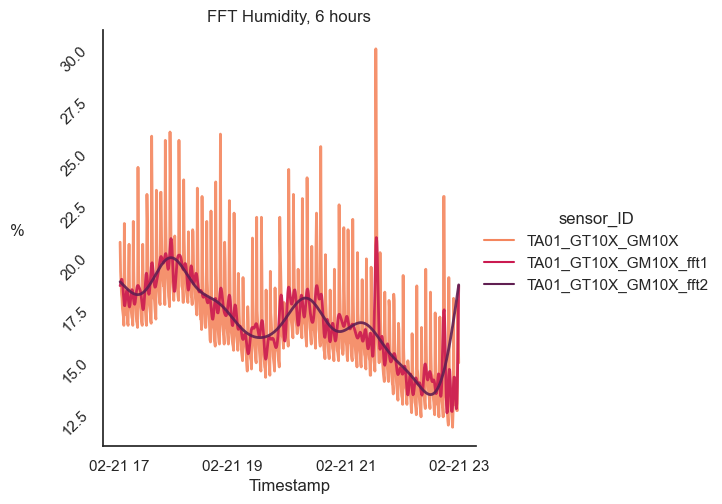

In [178]:
subset['TA01_GT10X_GM10X_fft1'] = filtered1[-720:]
subset['TA01_GT10X_GM10X_fft2'] = filtered2[-720:]
#subset = subset.drop(columns=['TA01_GT10X_GM10X_rolling'])

ax = sns.relplot(
    data=subset,
    kind='line',
    palette='rocket_r',
    alpha=0.9,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=2.0
)

ax.set_xticklabels(step=2)

plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('FFT Humidity, 6 hours')

fpath = plot_path + 'fft_humidity_6h.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()